# Walmart : predict weekly sales

In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold, learning_curve, validation_curve, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe_connected" # to be replaced by "iframe" if working on JULIE

In [2]:
walmart = pd.read_csv("Walmart_Store_sales.csv")

In [3]:
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [4]:
walmart.describe(include = 'all') #Dataset description

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


In [5]:
walmart.isna().sum()/len(walmart)*100 #Counting missing values percentages in each column

Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [6]:
walmart['Date'] = pd.to_datetime(walmart['Date']) #To Datetime format
walmart.dropna(subset=['Date'], inplace = True) #Dropping missing dates
walmart = walmart.sort_values(by="Date")

C:\Users\conta\AppData\Local\Temp\ipykernel_24860\1124888266.py:1: UserWarning:

Parsing '18-02-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\conta\AppData\Local\Temp\ipykernel_24860\1124888266.py:1: UserWarning:

Parsing '25-03-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\conta\AppData\Local\Temp\ipykernel_24860\1124888266.py:1: UserWarning:

Parsing '27-07-2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\conta\AppData\Local\Temp\ipykernel_24860\1124888266.py:1: UserWarning:

Parsing '28-05-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\conta\AppData\Local\Temp\ipykernel_24860\1124888266.py:1: UserWarning:

Parsing '19-08-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent 

In [7]:
walmart['Holiday_Flag'].value_counts() #Looking at holiday flag column

0.0    112
1.0     10
Name: Holiday_Flag, dtype: int64

In [8]:
display(walmart.loc[(walmart['Holiday_Flag'].isnull()),:]) #Displaying rows where holiday flag is missing

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
15,6.0,2010-04-30,1498080.16,NaN,68.91,2.780,211.894272,7.092
118,9.0,2010-06-18,513073.87,NaN,82.99,2.637,215.016648,6.384
73,1.0,2010-08-27,1449142.92,NaN,85.22,2.619,211.567306,7.787
90,9.0,2010-09-07,485389.15,NaN,78.51,2.642,214.656430,6.442
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858
53,14.0,2011-03-25,1879451.23,NaN,41.76,3.625,184.994368,8.549
48,1.0,2011-05-08,1624383.75,NaN,91.65,3.684,215.544618,7.962
136,4.0,2011-08-07,2066541.86,NaN,84.59,3.469,129.112500,5.644
43,7.0,2011-08-26,629994.47,NaN,57.60,3.485,194.379637,8.622
109,1.0,2011-09-12,NaN,NaN,43.93,3.158,218.961846,7.866


In [9]:
cal = calendar()
holidays = cal.holidays()
missing_hflag = walmart.loc[(walmart['Holiday_Flag'].isnull()),:]

#Replacing Holiday Flag's missing values via calendar
for row in walmart:
    for missing in missing_hflag:
        missing_hflag['Holiday_Flag'] = np.where(missing_hflag['Date'].isin(holidays), 1, 0)
        
display(missing_hflag) #Confirms every missing 'Holiday_Flag' can be considered as non flagged


C:\Users\conta\AppData\Local\Temp\ipykernel_24860\4231088477.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
15,6.0,2010-04-30,1498080.16,0,68.91,2.780,211.894272,7.092
118,9.0,2010-06-18,513073.87,0,82.99,2.637,215.016648,6.384
73,1.0,2010-08-27,1449142.92,0,85.22,2.619,211.567306,7.787
90,9.0,2010-09-07,485389.15,0,78.51,2.642,214.656430,6.442
0,6.0,2011-02-18,1572117.54,0,59.61,3.045,214.777523,6.858
53,14.0,2011-03-25,1879451.23,0,41.76,3.625,184.994368,8.549
48,1.0,2011-05-08,1624383.75,0,91.65,3.684,215.544618,7.962
136,4.0,2011-08-07,2066541.86,0,84.59,3.469,129.112500,5.644
43,7.0,2011-08-26,629994.47,0,57.60,3.485,194.379637,8.622
109,1.0,2011-09-12,NaN,0,43.93,3.158,218.961846,7.866


In [10]:
walmart.loc[(walmart['Holiday_Flag'].isnull()),'Holiday_Flag'] = missing_hflag['Holiday_Flag'] #Cleaning missing values in Walmart

In [11]:
walmart.isna().sum()/len(walmart)*100 #Getting proportions of missing values

Store            0.000000
Date             0.000000
Weekly_Sales    10.606061
Holiday_Flag     0.000000
Temperature     10.606061
Fuel_Price       9.848485
CPI              7.575758
Unemployment     9.090909
dtype: float64

#### Looks good. We Will deal with other (continuous numerical) missing values later, by imputation in the preprocessing phase

#### Let's look at our target : Weekly Sales

In [12]:
walmart.dropna(subset=['Weekly_Sales'], inplace = True) #Dropping null values
walmart.isna().sum()/len(walmart)*100

Store           0.000000
Date            0.000000
Weekly_Sales    0.000000
Holiday_Flag    0.000000
Temperature     9.322034
Fuel_Price      9.322034
CPI             7.627119
Unemployment    9.322034
dtype: float64

In [13]:
walmart['Week'] = walmart['Date'].dt.week
walmart['Month'] = walmart['Date'].dt.month
walmart['Year'] = walmart['Date'].dt.year
walmart

C:\Users\conta\AppData\Local\Temp\ipykernel_24860\2194179792.py:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year
14,17.0,2010-01-10,829207.27,0.0,60.07,2.853,126.234600,6.885,1,1,2010
20,7.0,2010-02-04,561145.14,0.0,38.26,2.725,189.704822,8.963,5,2,2010
99,13.0,2010-02-07,2018314.71,0.0,78.82,2.814,126.139200,7.951,5,2,2010
47,19.0,2010-02-07,1549018.68,0.0,66.25,2.958,132.521867,8.099,5,2,2010
115,15.0,2010-02-19,660838.75,0.0,NaN,2.909,131.637000,NaN,7,2,2010
...,...,...,...,...,...,...,...,...,...,...,...
74,1.0,2012-10-19,1508068.77,0.0,67.97,3.594,223.425723,NaN,42,10,2012
144,3.0,2012-10-19,424513.08,0.0,73.44,3.594,226.968844,6.034,42,10,2012
87,3.0,2012-11-05,431985.36,0.0,75.19,3.688,225.235150,6.664,45,11,2012
25,17.0,2012-12-10,919878.34,0.0,44.82,3.797,131.108333,5.527,50,12,2012


In [14]:
px.scatter(walmart, 
            x = 'Date' , 
            y = 'Weekly_Sales', 
            color = 'Store',
            title = 'Weekly Sales by Date'
    )

In [15]:
px.histogram(walmart, 
            x = 'Month' , 
            y = 'Weekly_Sales',
            color ='Year',
            nbins = 36,
            title = 'Weekly Sales by month of year'
    )

In [16]:
px.histogram(walmart, 
            x = 'Week' , 
            y = 'Weekly_Sales',
            color ='Year',
            nbins = walmart['Week'].nunique(),
            title = 'Weekly Sales by week of year'
    )

Dropping outlayers

In [17]:

mask = (walmart['Weekly_Sales'] < (walmart['Weekly_Sales'].mean() + 3*walmart['Weekly_Sales'].std())) & (walmart['Weekly_Sales'] > (walmart['Weekly_Sales'].mean() - 3*walmart['Weekly_Sales'].std())) #3 standard deviations
walmart = walmart.loc[mask,:]

#Drop temperature outlayers
mask1 = (walmart['Temperature'] < (walmart['Temperature'].mean() + 3*walmart['Temperature'].std())) & (walmart['Temperature'] > (walmart['Temperature'].mean() - 3*walmart['Temperature'].std())) #3 standard deviations 
walmart = walmart.loc[mask1,:]

#Drop fuelprice outlayers
mask2 = (walmart['Fuel_Price'] < (walmart['Fuel_Price'].mean() + 3*walmart['Fuel_Price'].std())) & (walmart['Fuel_Price'] > (walmart['Fuel_Price'].mean() - 3*walmart['Fuel_Price'].std())) #3 standard deviations 
walmart = walmart.loc[mask1,:]

#Drop cpi outlayers
mask2 = (walmart['CPI'] < (walmart['CPI'].mean() + 3*walmart['CPI'].std())) & (walmart['CPI'] > (walmart['CPI'].mean() - 3*walmart['CPI'].std())) #3 standard deviations 
walmart = walmart.loc[mask2,:]

#Drop unemployment outlayers
mask3 = (walmart['Unemployment'] < (walmart['Unemployment'].mean() + 3*walmart['Unemployment'].std())) & (walmart['Unemployment'] > (walmart['Unemployment'].mean() - 3*walmart['Unemployment'].std())) #3 standard deviations 
walmart = walmart.loc[mask3,:]

In [18]:
walmart.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year
count,86.000000,8.600000e+01,86.000000,86.000000,80.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,9.569767,1.229427e+06,0.069767,60.934767,3.290700,180.514234,7.297116,26.569767,6.616279,2010.883721
std,6.100223,6.733086e+05,0.256249,17.521077,0.491223,39.184261,0.969885,14.709373,3.392617,0.831987
min,1.000000,2.689290e+05,0.000000,18.790000,2.548000,126.126600,5.143000,1.000000,1.000000,2010.000000
25%,4.000000,5.398411e+05,0.000000,45.970000,2.804000,132.602339,6.504250,14.250000,4.000000,2010.000000
50%,8.000000,1.316480e+06,0.000000,61.450000,3.390500,197.500965,7.343000,25.000000,6.000000,2011.000000
75%,14.750000,1.807159e+06,0.000000,75.287500,3.689750,214.783750,8.074500,40.000000,10.000000,2012.000000
max,20.000000,2.771397e+06,1.000000,91.650000,4.170000,226.968844,9.524000,52.000000,12.000000,2012.000000


### Some more visualizations

In [19]:
fig = make_subplots(rows=4, cols=1, subplot_titles=("Unemployment", "Fuel price",  "Temperature"))

fig.add_trace(go.Scatter(x = walmart['Unemployment'], y = walmart['Weekly_Sales'], mode='markers',), row=1, col=1)

fig.add_trace(go.Histogram(x = walmart['Fuel_Price'], y = walmart['Weekly_Sales'], nbinsx = 20), row=2, col=1)

fig.add_trace(go.Histogram(x = walmart['Temperature'], y = walmart['Weekly_Sales'], nbinsx = 15), row=3, col=1)

fig.add_trace(go.Histogram(x = walmart['CPI'], y = walmart['Weekly_Sales'], nbinsx = 15), row=4, col=1)

fig.update_layout(height=600, width=800, title_text="Unemployment, Fuel price and Temp impact on Sales")

fig.show()

<AxesSubplot:>

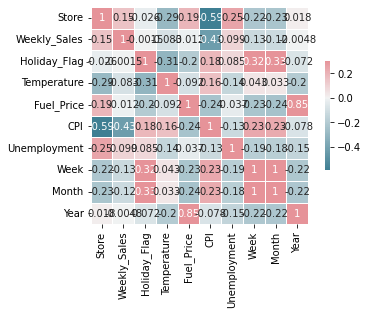

In [20]:
corr = walmart.corr()
sns.heatmap(corr, vmax=.3, center=0, annot=True,
            cmap = sns.diverging_palette(220, 10, as_cmap=True),
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### We will get rid of 'year' and 'month' columns since 'month' and 'week' have a correlation of 1. 'year' and 'fuel_price' are pretty much correlated too. Let's not keep our 'year' column, keeping in mind it could have a slight influence on predictions.

# Pre processing

In [40]:
walmart = walmart.loc[:,['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Week']]
walmart = walmart.reset_index(drop = True)
print("Separating labels from features...")

target_name = 'Weekly_Sales'

Y = walmart.loc[:,target_name]
X = walmart.loc[:,[c for c in walmart.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0     829207.27
1     561145.14
2    2018314.71
3    1549018.68
4    1427023.45
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0   17.0           0.0        60.07       2.853  126.234600         6.885   
1    7.0           0.0        38.26       2.725  189.704822         8.963   
2   13.0           0.0        78.82       2.814  126.139200         7.951   
3   19.0           0.0        66.25       2.958  132.521867         8.099   
4   19.0           0.0        39.07       2.963  131.863129         8.350   

   Week  
0     1  
1     5  
2     5  
3     5  
4    12  



In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [42]:
#Imputing missing values & Normalizing
# Create pipeline for numeric features
numeric_features = [2,3,4,5,6] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = [0, 1] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [43]:
#Converting pandas DataFrames to numpy arrays
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

In [44]:
X_train = preprocessor.fit_transform(X_train)

In [45]:
X_train

<60x24 sparse matrix of type '<class 'numpy.float64'>'
	with 352 stored elements in Compressed Sparse Row format>

In [46]:
X_test = preprocessor.transform(X_test)

### Training - testing basic model

In [47]:
# Training model
regressor = LinearRegression() 
regressor.fit(X_train, Y_train)

LinearRegression()

In [48]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print(Y_train_pred[0:5])

Predictions on training set...
[2000926.12487428 2042798.1429414  1410556.60114257  346340.93024671
 1915878.52191128]


In [49]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print(Y_test_pred[0:5])

Predictions on test set...
[1969261.15937364 1361030.1772228  2142514.27903278  488358.92965021
 2093530.1054782 ]


In [50]:
print("R2-score on train set : ",r2_score(Y_train, Y_train_pred))
print("R2-score on test set : ", r2_score(Y_test, Y_test_pred))

R2-score on train set :  0.9832350142042391
R2-score on test set :  0.9451896086567125


### We might be overfitting, let's verify it

In [51]:
#Cross-validated score for a Ridge model (with default value of λ)
reg = Ridge()
print('The standard deviation is : ',cross_val_score(regressor, X_train, Y_train).std())
print('Difference between train and test scores is : ', r2_score(Y_train, Y_train_pred) - r2_score(Y_test, Y_test_pred))

The standard deviation is :  0.3667932621920246
Difference between train and test scores is :  0.038045405547526556


### Our model was slighlty overfitting. After trying different regularization models, Lasso regularization had the best scores.

In [52]:
# Perform 10-fold cross-validation to evaluate the generalized R2 score obtained with a Lasso model
lasso = Lasso()

params = {
    'alpha': [10**a for a in range(20)]  # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(lasso, param_grid = params, cv = KFold(n_splits=10, shuffle=True, random_state=0)) #we use Kfold here to shuffle the dataset
gridsearch.fit(X_train, Y_train)

c:\users\conta\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 191573305031.58728, tolerance: 2212617347.659601

c:\users\conta\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 164551810759.1833, tolerance: 2110199877.8984153

c:\users\conta\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 188725713242.35675, tolerance: 2220353159.357077

c:\users\conta\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:



GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [1, 10, 100, 1000, 10000, 100000, 1000000,
                                   10000000, 100000000, 1000000000, 10000000000,
                                   100000000000, 1000000000000, 10000000000000,
                                   100000000000000, 1000000000000000,
                                   10000000000000000, 100000000000000000,
                                   1000000000000000000, 10000000000000000000]})

In [53]:
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)
reg_model = gridsearch.best_estimator_

Best hyperparameters :  {'alpha': 10}
Best R2 score :  0.8870113159187689


In [54]:
print("Lasso R2 score on training set : ", reg_model.score(X_train, Y_train))
print("Lasso R2 score on test set : ", reg_model.score(X_test, Y_test))
print("Average absolute error on test set : ", mean_absolute_error(Y_test, Y_test_pred).round(2),'$')

Lasso R2 score on training set :  0.982896985286693
Lasso R2 score on test set :  0.9452285970266003
Average absolute error on test set :  120423.42 $


### This regularization reduced overfitting by some thousandths, we'll keep this model as our best estimator and look at the features it considered as most important.

In [55]:
#There are lasso model coefficients
#NB: 'Stores' column has been onehot encoded, we have to get the columns names from the encoder ro display every coefficient next to his feature.
coefs = reg_model.coef_

print('There are', len(coefs), 'coefficients')
coefs

There are 24 coefficients


array([  -24285.44520623,   -24160.11020958,   424315.37164124,
          43991.46681405,    20942.36461685,   249026.91403942,
       -1167838.31136314,  1599077.64125237, -1211907.50065858,
          98768.46619111,  -852743.94674088,  -655862.53703814,
       -1025840.03130942,  1252433.23040379,   113458.79456823,
        1420058.82202398,   706194.47329723,    75148.94706676,
        -788047.4244397 ,   308774.74110147,   313601.6369346 ,
         682081.45256577,   610652.98041779,    41797.00011215])

In [78]:
# Creating a list with our categorical and numerical features, in right order (as encoded)

num_features = X.columns[2:].tolist()
num_features

['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week']

In [79]:
preprocessor.transformers_[1][1].steps[1][1] #This is where our Onehot encoder is located in preprocessor
cat_features = preprocessor.transformers_[1][1].steps[1][1].get_feature_names_out().tolist()#extracting columns names from 'categorical' features
cat_features

['x0_2.0',
 'x0_3.0',
 'x0_4.0',
 'x0_5.0',
 'x0_6.0',
 'x0_7.0',
 'x0_8.0',
 'x0_9.0',
 'x0_10.0',
 'x0_11.0',
 'x0_13.0',
 'x0_14.0',
 'x0_15.0',
 'x0_16.0',
 'x0_17.0',
 'x0_18.0',
 'x0_19.0',
 'x0_20.0',
 'x1_1.0']

In [80]:
all_features = num_features
all_features.extend(cat_features)

print('There are', len(all_features), 'encoded features')
all_features

There are 24 encoded features


['Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'Week',
 'x0_2.0',
 'x0_3.0',
 'x0_4.0',
 'x0_5.0',
 'x0_6.0',
 'x0_7.0',
 'x0_8.0',
 'x0_9.0',
 'x0_10.0',
 'x0_11.0',
 'x0_13.0',
 'x0_14.0',
 'x0_15.0',
 'x0_16.0',
 'x0_17.0',
 'x0_18.0',
 'x0_19.0',
 'x0_20.0',
 'x1_1.0']

In [88]:
coefs_df = pd.DataFrame(coefs, columns = ['coefficients'], index = all_features)
coefs_df['coefficients'] = coefs_df['coefficients'].apply(lambda x : abs(x)) 
coefs_df = coefs_df.sort_values('coefficients',ascending=False) #Looking at the absolute values to see features importances whether they have negative or positive impact.
coefs_df

,coefficients
x0_4.0,1.599078e+06
x0_13.0,1.420059e+06
x0_10.0,1.252433e+06
x0_5.0,1.211908e+06
x0_3.0,1.167838e+06
x0_9.0,1.025840e+06
x0_7.0,8.527439e+05
x0_16.0,7.880474e+05
x0_14.0,7.061945e+05
x0_19.0,6.820815e+05


In [90]:
# Looking at model's feature importance on a bar plot

px.histogram(x = coefs_df.index, y = coefs_df.coefficients)

In [ ]:
### Acording to our model, the ost important feature to predict weekly sales is the store. This information would give more insights if we could locate each store so we'd see which store/city is the most profitable.